In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime, timedelta
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from sklearn.neighbors import BallTree
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

In [2]:
def standardize_features(df, feature_columns):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[feature_columns] = scaler.fit_transform(df[feature_columns])
    return df_scaled

def load_and_prepare_data(calendar_path, listings_path, n_listings=500):
    """Load and prepare the data with basic cleaning and sampling."""
    # Load listings first to get the sample
    listings_df = pd.read_csv(listings_path)
    sampled_listings = listings_df['id'].sample(n=n_listings, random_state=42)
    
    # Clean and prepare listings data
    listings_cleaned = listings_df[listings_df['id'].isin(sampled_listings)][
        ['id', 'neighbourhood_cleansed', 'latitude', 'longitude']
    ]
    listings_cleaned = listings_cleaned.rename(columns={'id': 'listing_id'})
    
    # Load and filter calendar data
    calendar_df = pd.read_csv(calendar_path)
    calendar_df = calendar_df[calendar_df['listing_id'].isin(sampled_listings)]
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    
    # Merge calendar with listings data
    df = pd.merge(calendar_df, listings_cleaned, on='listing_id', how='left')
    
    print(f"Total listings in sample: {len(df['listing_id'].unique())}")
    print(f"Total records in sample: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    
    return df

def extract_tsfresh_features(df):
    """Extract time series features using tsfresh."""
    # Create a proper time series dataframe for tsfresh
    df_tsfresh = df[['listing_id', 'date', 'price']].copy()
    #df_tsfresh['price'] = clean_price(df_tsfresh['price'])
    df_tsfresh = df_tsfresh.sort_values(['listing_id', 'date'])
   
    # Create rolling windows
    df_rolled = roll_time_series(
        df_tsfresh,
        column_id='listing_id',
        column_sort='date',
        max_timeshift=7,
        rolling_direction=1
    )
   
    # Define minimal but meaningful feature set
    fc_parameters = {
        "mean": None,
        "median": None,
        "standard_deviation": None,
        "variance": None,
        "maximum": None,
        "minimum": None,
        "mean_change": None,
        "mean_abs_change": None
    }
   
    try:
        features_filtered = extract_features(
            df_rolled,
            column_id='listing_id',
            column_sort='date',
            column_value='price',
            default_fc_parameters=fc_parameters,
            n_jobs=0
        )
       
        # Validate features
        features_filtered = features_filtered.replace([np.inf, -np.inf], np.nan)
        features_filtered = features_filtered.dropna(axis=1, how='all')
        non_constant_cols = features_filtered.columns[features_filtered.nunique() > 1]
        features_filtered = features_filtered[non_constant_cols]
       
        print(f"\nExtracted {len(non_constant_cols)} valid tsfresh features")
        return features_filtered
       
    except Exception as e:
        print(f"Error in tsfresh feature extraction: {str(e)}")
        return pd.DataFrame()

def create_history_features(df, history_window=365, forecast_horizon=60):
    """Create standardized lagged features."""
    df['price_numeric'] = pd.to_numeric(df['price'].replace(r'[\$,]', '', regex=True), errors='coerce')
    df = df.sort_values(['listing_id', 'date'])
    
    processed_data = []
    
    for listing_id in df['listing_id'].unique():
        listing_data = df[df['listing_id'] == listing_id].copy()
        
        # Create lag features
        for i in range(1, 181, 30):
            listing_data[f'price_lag_{i}d'] = listing_data['price_numeric'].shift(i)
        for i in range(181, 366, 90):
            listing_data[f'price_lag_{i}d'] = listing_data['price_numeric'].shift(i)
        
        # Create rolling statistics
        windows = [30, 90, 180, 365]
        for window in windows:
            listing_data[f'rolling_mean_{window}d'] = listing_data['price_numeric'].rolling(window=window).mean()
            listing_data[f'rolling_std_{window}d'] = listing_data['price_numeric'].rolling(window=window).std()
            listing_data[f'rolling_max_{window}d'] = listing_data['price_numeric'].rolling(window=window).max()
            listing_data[f'rolling_min_{window}d'] = listing_data['price_numeric'].rolling(window=window).min()
        
        listing_data['yoy_price_change'] = listing_data['price_numeric'] / listing_data['price_numeric'].shift(365) - 1
        listing_data['target_price'] = listing_data['price_numeric'].shift(-forecast_horizon)
        
        processed_data.append(listing_data)
    
    processed_df = pd.concat(processed_data)
    
    # Standardize all price-related features
    price_features = [col for col in processed_df.columns if any(x in col for x in ['price_lag_', 'rolling_'])]
    processed_df = standardize_features(processed_df, price_features)
    
    return processed_df.dropna()

def prepare_features_with_history(df, tsfresh_features, history_window=365, forecast_horizon=60):
    """Enhanced feature preparation including spatial features."""
    # Create temporal features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['season_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear/365.25)
    df['season_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear/365.25)
    
    # Add history-based features
    df_with_history = create_history_features(df, history_window, forecast_horizon)
    
    # Create spatial features
    spatial_features = create_spatial_features(df_with_history)
    df_with_history = pd.concat([df_with_history, spatial_features], axis=1)
    
    # Encode categorical variables
    le = LabelEncoder()
    df_with_history['neighbourhood_cleansed_encoded'] = le.fit_transform(
        df_with_history['neighbourhood_cleansed'].fillna('Unknown')
    )
    
    # Define feature sets
    basic_features = [
        'day_of_week', 'month', 'is_weekend', 'season_sin', 'season_cos',
        'neighbourhood_cleansed_encoded', 'latitude', 'longitude'
    ]
    
    lag_features = [col for col in df_with_history.columns if 'price_lag_' in col]
    rolling_features = [col for col in df_with_history.columns if 'rolling_' in col]
    spatial_feature_cols = spatial_features.columns.tolist()
    
    all_features = (
        basic_features + 
        lag_features + 
        rolling_features + 
        spatial_feature_cols + 
        ['yoy_price_change']
    )
    
    X = df_with_history[all_features]
    
    return X, df_with_history['target_price'], df_with_history['date']

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points using the Haversine formula.
    Returns distance in kilometers.
    """
    R = 6371  # Earth's radius in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

def create_spatial_features(df, k_neighbors=5):
    """
    Create spatial features combining:
    - Distance to city center
    - North-South position
    - K-nearest neighbors price statistics
    
    Args:
        df: DataFrame containing latitude, longitude and price
        k_neighbors: Number of nearest neighbors for price statistics
    """
    # City centers (approximate coordinates)
    city_centers = {
        'amsterdam': (52.3676, 4.9041),
        'paris': (48.8566, 2.3522),
        'london': (51.5074, -0.1278),
        'berlin': (52.5200, 13.4050),
        'rome': (41.9028, 12.4964),
        'barcelona': (41.3851, 2.1734)
    }
    
    # Determine which city based on coordinates
    sample_lat = df['latitude'].median()
    sample_lon = df['longitude'].median()
    
    # Find closest city center
    closest_city = min(city_centers.items(), 
                      key=lambda x: calculate_distance(sample_lat, sample_lon, x[1][0], x[1][1]))
    
    city_center_lat, city_center_lon = city_centers[closest_city[0]]
    print(f"Using {closest_city[0].title()} as reference city")
    
    # Create spatial features DataFrame
    spatial_features = pd.DataFrame(index=df.index)
    
    # 1. Basic spatial features
    # Distance to city center
    spatial_features['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    )
    
    # North-South position relative to city center
    spatial_features['north_south'] = df['latitude'] - city_center_lat
    
    # Normalized latitude (0 = southernmost, 1 = northernmost)
    min_lat = df['latitude'].min()
    max_lat = df['latitude'].max()
    spatial_features['normalized_latitude'] = (df['latitude'] - min_lat) / (max_lat - min_lat)
    
    # 2. K-Nearest Neighbors Price Statistics
    # Convert price to numeric if needed
    if not pd.api.types.is_numeric_dtype(df['price']):
        price_numeric = pd.to_numeric(df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')
    else:
        price_numeric = df['price']
    
    # Convert coordinates to radians for BallTree
    coords = np.radians(df[['latitude', 'longitude']].values)
    
    # Create BallTree for efficient nearest neighbor search
    tree = BallTree(coords, metric='haversine')
    
    # Get indices and distances for k nearest neighbors
    distances, indices = tree.query(coords, k=k_neighbors + 1)  # +1 because first point is self
    distances = distances * 6371.0  # Convert to kilometers (Earth radius)
    
    # Calculate neighbor price statistics
    neighbor_prices = np.array([price_numeric.iloc[idx[1:]].values for idx in indices])
    
    spatial_features['knn_price_mean'] = np.nanmean(neighbor_prices, axis=1)
    spatial_features['knn_price_std'] = np.nanstd(neighbor_prices, axis=1)
    spatial_features['price_diff_from_neighbors'] = price_numeric.values - spatial_features['knn_price_mean']
    
    print("Created spatial features:")
    print("- distance_to_center: Distance in km from city center")
    print("- north_south: Positive values are north of city center")
    print("- normalized_latitude: 0-1 scale from south to north")
    print("- knn_price_mean: Average price of k nearest neighbors")
    print("- knn_price_std: Standard deviation of k nearest neighbor prices")
    print("- price_diff_from_neighbors: Price difference from neighbor average")
    
    # Before returning, standardize all price and distance features
    features_to_standardize = [
        'distance_to_center',
        'knn_price_mean',
        'knn_price_std',
        'price_diff_from_neighbors'
    ]
    
    spatial_features = standardize_features(spatial_features, features_to_standardize)
    
    return spatial_features

def evaluate_model_performance(y_true, y_pred, dates, coordinates, window_size=30):
        
    # Initialize results dictionary
    results = {}
    
    # 1. Traditional Metrics
    results['traditional'] = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    
    # Create DataFrame for temporal analysis
    df = pd.DataFrame({
        'date': dates,
        'true': y_true,
        'pred': y_pred,
        'error': y_true - y_pred,
        'abs_error': np.abs(y_true - y_pred),
        'pct_error': np.abs((y_true - y_pred) / y_true) * 100
    })
    
    # 2. Temporal Analysis
    # Monthly metrics
    monthly_metrics = df.set_index('date').resample('ME').agg({
        'abs_error': ['mean', 'std'],
        'pct_error': ['mean', 'std']
    })
    
    # Error stability (rolling statistics)
    rolling_metrics = df.set_index('date').rolling(window=window_size, min_periods=1).agg({
        'abs_error': ['mean', 'std'],
        'pct_error': ['mean', 'std']
    })
    
    # Error autocorrelation (lag-1)
    error_autocorr = df['error'].autocorr(lag=1)
    
    results['temporal'] = {
        'monthly_metrics': monthly_metrics,
        'rolling_metrics': rolling_metrics,
        'error_autocorr': error_autocorr
    }
    
    # 3. Improved Spatial Analysis
    # Compute distance matrix
    dist_matrix = squareform(pdist(coordinates))
    
    # Create more meaningful distance bands (in km)
    distance_bins = [0, 0.5, 1, 2, 5]  # 0-0.5km, 0.5-1km, 1-2km, 2-5km
    distance_labels = ['0-0.5km', '0.5-1km', '1-2km', '2-5km']
    
    spatial_error_analysis = []
    errors = df['error'].values
    
    for i in range(len(distance_bins)-1):
        # Create mask for current distance band
        mask = (dist_matrix > distance_bins[i]) & (dist_matrix <= distance_bins[i+1])
        
        # Initialize lists for error statistics
        band_errors = []
        
        # Calculate mean absolute error difference for each point with its neighbors in the band
        for j in range(len(errors)):
            neighbor_indices = np.where(mask[j])[0]
            if len(neighbor_indices) > 0:
                current_error = errors[j]
                neighbor_errors = errors[neighbor_indices]
                
                # Calculate mean absolute difference in errors
                error_diff = np.mean(np.abs(current_error - neighbor_errors))
                band_errors.append(error_diff)
        
        # Store statistics for this distance band
        spatial_error_analysis.append({
            'distance_band': distance_labels[i],
            'mean_error_diff': np.mean(band_errors) if band_errors else np.nan,
            'std_error_diff': np.std(band_errors) if band_errors else np.nan,
            'n_samples': len(band_errors)
        })
    
    results['spatial'] = pd.DataFrame(spatial_error_analysis)
    
    return results

def print_evaluation_summary(results):
    """
    Print a formatted summary of the evaluation results.
    """
    print("\nTraditional Metrics:")
    print("-" * 50)
    for metric, value in results['traditional'].items():
        print(f"{metric.upper()}: {value:.4f}")
    
    print("\nTemporal Analysis:")
    print("-" * 50)
    print(f"Error Autocorrelation (lag-1): {results['temporal']['error_autocorr']:.4f}")
    print("\nMonthly Error Statistics:")
    print(results['temporal']['monthly_metrics'].round(4))
    
    print("\nSpatial Error Analysis:")
    print("-" * 50)
    print("Average error differences by distance:")
    print(results['spatial'].round(4))

def create_evaluation_plots(results):
    """
    Create improved visualization plots for the evaluation results using seaborn.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot 1: Rolling Error Metrics with improvements
    rolling_metrics = results['temporal']['rolling_metrics']
    
    # Calculate weekly averages for cleaner visualization
    weekly_means = rolling_metrics['abs_error']['mean'].resample('W').mean()
    weekly_stds = rolling_metrics['abs_error']['std'].resample('W').mean()
    
    # Use seaborn color palette
    color = sns.color_palette("husl", 8)[0]
    
    sns.lineplot(x=weekly_means.index, y=weekly_means, 
                label='Weekly MAE', ax=ax1, 
                color=color, linewidth=2)
    
    ax1.fill_between(
        weekly_means.index,
        weekly_means - weekly_stds,
        weekly_means + weekly_stds,
        alpha=0.2,
        color=color
    )
    
    sns.despine(ax=ax1)
    ax1.set_title('Weekly Mean Absolute Error with Standard Deviation',
                 pad=20, fontsize=12, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Error', fontsize=10)
    
    # Auto-adjust y-axis to data
    y_max = weekly_means.max() + weekly_stds.max()
    ax1.set_ylim(0, min(y_max * 1.2, 100))  # Cap at 100 or 120% of max
    
    # Plot 2: Monthly Error Patterns
    monthly_data = results['temporal']['monthly_metrics']
    
    # Create monthly plot using seaborn
    months = monthly_data.index.strftime('%Y-%m')
    monthly_plot_data = pd.DataFrame({
        'Month': months,
        'Mean Error': monthly_data['abs_error']['mean'],
        'Std Error': monthly_data['abs_error']['std']
    })
    
    sns.barplot(data=monthly_plot_data, 
                x='Month', 
                y='Mean Error',
                ax=ax2,
                color=sns.color_palette("husl", 8)[1])
    
    # Add error bars
    ax2.errorbar(x=range(len(months)), 
                y=monthly_plot_data['Mean Error'],
                yerr=monthly_plot_data['Std Error'],
                fmt='none', 
                color='black',
                capsize=5)
    
    sns.despine(ax=ax2)
    ax2.set_title('Monthly Error Patterns',
                 pad=20, fontsize=12, fontweight='bold')
    ax2.set_xlabel('Month', fontsize=10)
    ax2.set_ylabel('Mean Absolute Error', fontsize=10)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Improved Spatial Error Analysis
    spatial_results = results['spatial']
    
    # Only plot bands with data
    valid_bands = spatial_results[spatial_results['n_samples'] > 0]
    
    if not valid_bands.empty:
        sns.barplot(data=valid_bands, 
                   x='distance_band', 
                   y='mean_error_diff',
                   ax=ax3,
                   color=sns.color_palette("husl", 8)[2])
        
        # Add error bars
        ax3.errorbar(x=range(len(valid_bands)), 
                    y=valid_bands['mean_error_diff'],
                    yerr=valid_bands['std_error_diff'],
                    fmt='none', 
                    color='black',
                    capsize=5)
        
        # Add sample size annotations
        for i, row in valid_bands.iterrows():
            ax3.text(i, row['mean_error_diff'], 
                    f'n={row["n_samples"]}', 
                    ha='center', va='bottom',
                    fontsize=9)
    
    sns.despine(ax=ax3)
    ax3.set_title('Error Differences by Distance Band',
                 pad=20, fontsize=12, fontweight='bold')
    ax3.set_xlabel('Distance Band', fontsize=10)
    ax3.set_ylabel('Mean Error Difference', fontsize=10)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Add a title to the entire figure
    fig.suptitle('Model Error Analysis', 
                fontsize=14, 
                fontweight='bold',
                y=1.02)
    
    plt.show()

def train_model_with_history(X, y, dates):
    """Train XGBoost model using 1 year of data and predict 2 months ahead."""
    # Calculate cutoff dates
    latest_date = dates.max()
    training_start = latest_date - timedelta(days=365)  # 1 year
    validation_start = latest_date - timedelta(days=60)  # Last 2 months for validation
    
    # Split data based on dates
    train_mask = (dates >= training_start) & (dates < validation_start)
    test_mask = dates >= validation_start
    
    # Split features and target
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    print("\nData Split Information:")
    print(f"Training period: {dates[train_mask].min()} to {dates[train_mask].max()}")
    print(f"Testing period: {dates[test_mask].min()} to {dates[test_mask].max()}")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize XGBoost with parameters tuned for longer forecast horizon
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping=20
    )
    
    # Train model
    xgb_model.fit(
        X_train_scaled, 
        y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )
    
    return xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, dates[test_mask]

In [3]:
calendar_path = r'C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\paris_merged_calendar.csv'
listings_path = r'C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\listings.csv'

print("Loading and preparing data...")
df = load_and_prepare_data(calendar_path, listings_path, n_listings=500)

print("Extracting tsfresh features...")
tsfresh_features = extract_tsfresh_features(df)

print("Preparing features with history...")
X, y, dates = prepare_features_with_history(
    df, 
    tsfresh_features,
    history_window=365,  # Full year of history
    forecast_horizon=60  # 2 months ahead
)

print("\nTraining model...")
model, X_train_scaled, X_test_scaled, y_train, y_test, test_dates = train_model_with_history(X, y, dates)

print("\nMaking predictions...")
y_pred = model.predict(X_test_scaled)

print("Done")

Loading and preparing data...
Total listings in sample: 500
Total records in sample: 332673
Date range: 2023-06-07 00:00:00 to 2025-09-12 00:00:00
Extracting tsfresh features...


Feature Extraction: 100%|██████████| 500/500 [00:00<00:00, 1377.43it/s]



Extracted 8 valid tsfresh features
Preparing features with history...
Using Paris as reference city
Created spatial features:
- distance_to_center: Distance in km from city center
- north_south: Positive values are north of city center
- normalized_latitude: 0-1 scale from south to north
- knn_price_mean: Average price of k nearest neighbors
- knn_price_std: Standard deviation of k nearest neighbor prices
- price_diff_from_neighbors: Price difference from neighbor average

Training model...

Data Split Information:
Training period: 2024-07-14 00:00:00 to 2025-05-14 00:00:00
Testing period: 2025-05-15 00:00:00 to 2025-07-14 00:00:00
Training samples: 90699
Testing samples: 23432


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping" } are not used.

  warnings.warn(smsg, UserWarning)



Making predictions...
Done



Traditional Metrics:
--------------------------------------------------
RMSE: 41.3411
MAE: 12.0789
R2: 0.9948
MAPE: 6.2875

Temporal Analysis:
--------------------------------------------------
Error Autocorrelation (lag-1): 0.9741

Monthly Error Statistics:
           abs_error          pct_error        
                mean      std      mean     std
date                                           
2025-05-31   10.0176  28.1528    6.5289  7.4075
2025-06-30   12.3765  40.8003    6.3353  7.4932
2025-07-31   13.9770  47.8553    5.8468  7.1716

Spatial Error Analysis:
--------------------------------------------------
Average error differences by distance:
  distance_band  mean_error_diff  std_error_diff  n_samples
0       0-0.5km          18.8701         38.3532      23432
1       0.5-1km              NaN             NaN          0
2         1-2km              NaN             NaN          0
3         2-5km              NaN             NaN          0


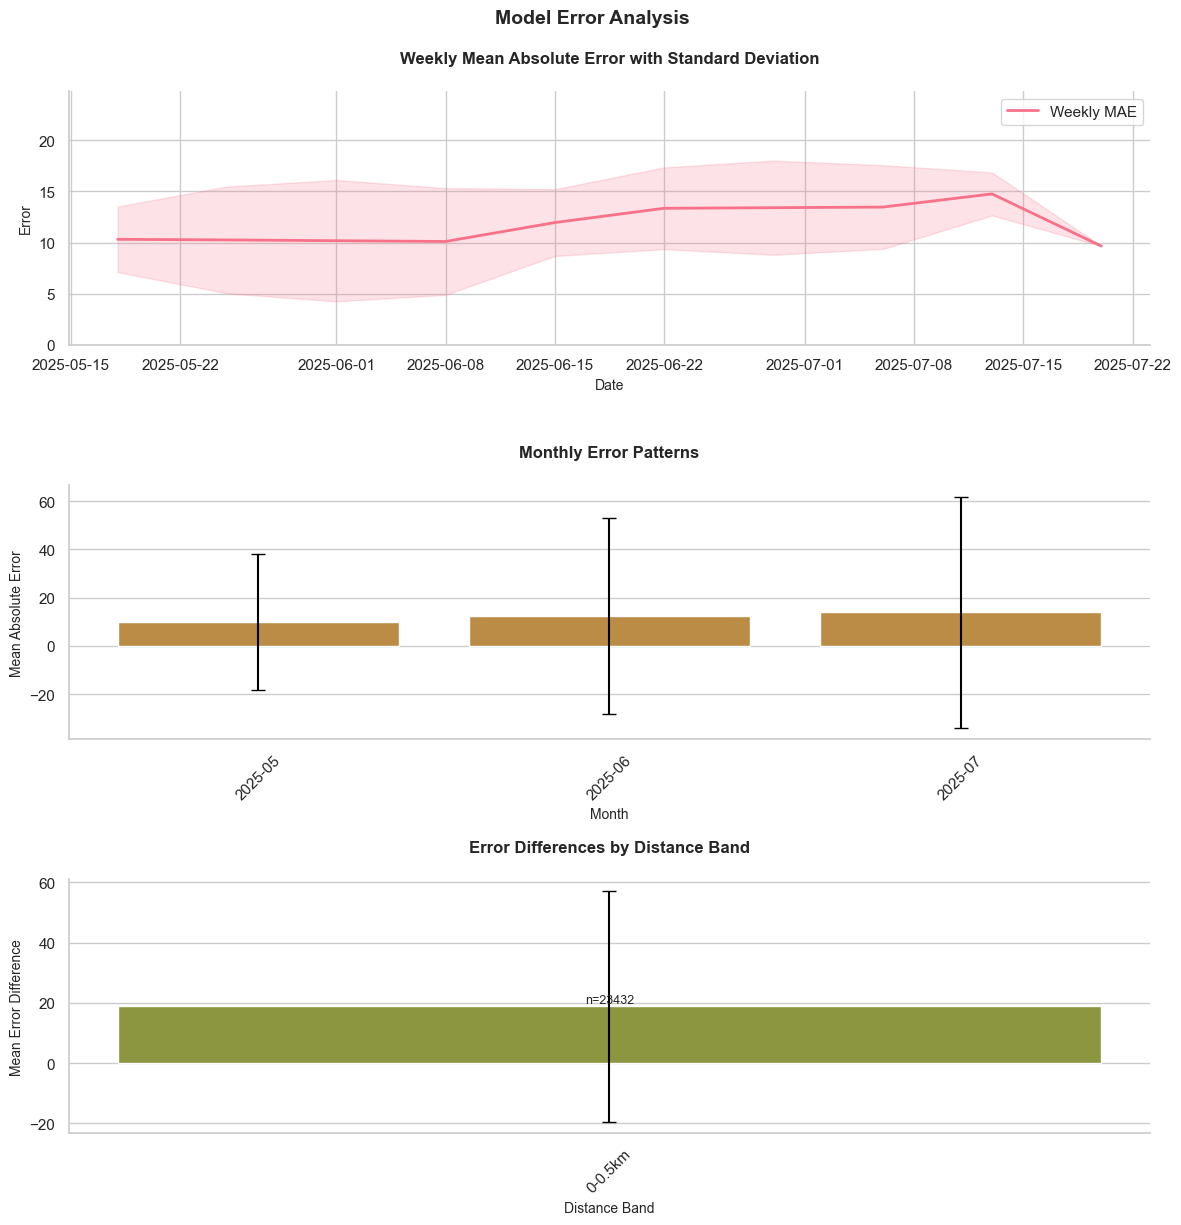


Top 10 Most Important Features:
                           feature  importance
10                   price_lag_61d    0.346184
9                    price_lag_31d    0.252143
8                     price_lag_1d    0.245227
20                 rolling_min_30d    0.066930
28                rolling_min_180d    0.030816
24                 rolling_min_90d    0.023543
21                rolling_mean_90d    0.009334
5   neighbourhood_cleansed_encoded    0.007514
36                  knn_price_mean    0.005815
11                   price_lag_91d    0.004509

Prediction Error by Month:
First Month:
Mean Absolute Error: 10.26
Mean Percentage Error: 6.51%

Second Month:
Mean Absolute Error: 13.70
Mean Percentage Error: 6.09%


In [4]:
# Get coordinates for spatial analysis
latest_date = dates.max()
validation_start = latest_date - timedelta(days=60)
test_mask = dates >= validation_start
X_test = X[test_mask]
coordinates = X_test[['latitude', 'longitude']].values

# Evaluate model
evaluation_results = evaluate_model_performance(
    y_test,
    y_pred,
    test_dates,
    coordinates
)

# Print summary and create plots
print_evaluation_summary(evaluation_results)
create_evaluation_plots(evaluation_results)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

results_df = pd.DataFrame({
    'date': test_dates,
    'abs_error': np.abs(y_test - y_pred),
    'pct_error': np.abs((y_test - y_pred) / y_test) * 100
})

first_month_mask = results_df['date'] < (results_df['date'].min() + timedelta(days=30))
second_month_mask = ~first_month_mask

print("\nPrediction Error by Month:")
print("First Month:")
print(f"Mean Absolute Error: {results_df[first_month_mask]['abs_error'].mean():.2f}")
print(f"Mean Percentage Error: {results_df[first_month_mask]['pct_error'].mean():.2f}%")
print("\nSecond Month:")
print(f"Mean Absolute Error: {results_df[second_month_mask]['abs_error'].mean():.2f}")
print(f"Mean Percentage Error: {results_df[second_month_mask]['pct_error'].mean():.2f}%")